# Setup

In [1]:
from multiprocessing import Pool

import copy
import os
import yaml
import re

import numpy as np
import pandas as pd
import geopandas as gpd
import pypsa
import SALib
from SALib.analyze import pawn

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.io import shapereader
import searoute as sr

# Render matplotlib plots as svg when inline in notebook
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') 

In [2]:
MWh_per_tH2 = 33
inflation = 1.2723
cm = 1 / 2.54

# Area usage for onshore wind in Norway (https://www.nve.no/energi/energisystem/vindkraft/arealbruk-for-vindkraftverk/direkte-paavirket-areal/)
sqkm_per_MW = 1 / 8.6  # Exact number: 587 / 5050

# Offshore (https://veiledere.nve.no/havvind/identifisering-av-utredningsomrader-for-havvind/)
sqkm_per_MW_offshore = 1 / 5

ticksize = 8
labelsize = 8
titlesize = 9

configs = ["scenario_A", "scenario_B", "scenario_C"]

use_default_sweep = True

# param_sweep_hashes = {
#     "scenario_A": "7043b771",
#     "scenario_B": "7043b771",
#     "scenario_C": "768ba159",
# }

# Blue, green, dark green
config_colours = {
    "scenario_A": "#1f77b4",
    "scenario_B": "#2ca02c",
    "scenario_C": "#006400",
}

with open("../config/config.default.yaml", "r") as f:
    default_config = yaml.safe_load(f)

config_dicts = {}
for config in configs:
    with open(f"../results/{config}/config.yaml", "r") as f:
        config_dicts[config] = yaml.safe_load(f)

save_figs = True

In [3]:
def load_net(f):
    return f, pypsa.Network(f)


nets = {}
for config in configs:
    # Collect all files in nets_dir ending with .nc
    if use_default_sweep:
        nets_dir = f"../results/{config}/param_sweep"
    else:
        nets_dir = f"../results/{config}/param_sweeps/{param_sweep_hashes[config]}"
    net_files = [f for f in os.listdir(nets_dir) if f.endswith(".nc")]

    # Load networks in parallel, use map_async
    nets[config] = {}
    with Pool(40) as pool:
        for net_file, net in pool.map_async(
            load_net, [os.path.join(nets_dir, f) for f in net_files]
        ).get():
            nets[config][net_file] = net

INFO:pypsa.io:Imported network elec_s60_20_lc1.1__1000SEG-T-H-B-I-A-Co2L0.45-EXPORT2-onwind+c1.13-offwindfixed+c0.93-offwindfloat+c1.04-SMR CC+c1.0-gas+m0.98-co2 stored+c1.04-H2 Electrolysis+c1.16-H2 Electrolysis+f0.99-H2 export+c0.81-H2 export+m1.14_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s60_20_lc1.1__1000SEG-T-H-B-I-A-Co2L0.45-EXPORT2-onwind+c0.95-offwindfixed+c1.15-offwindfloat+c1.03-SMR CC+c0.99-gas+m1.07-co2 stored+c1.19-H2 Electrolysis+c1.06-H2 Electrolysis+f1.04-H2 export+c1.12-H2 export+m0.91_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s60_20_lc1.1__1000SEG-T-H-B-I-A-Co2L0.45-EXPORT2-onwind+c1.05-offwindfixed+c1.16-offwindfloat+c0.84-SMR CC+c1.13-gas+m1.01-co2 stored+c0.94-H2 Electrolysis+c0.98-H2 Electrolysis+f0.94-H2 export+c0.89-H2 export+m1.06_2030.nc has buses, carriers, generato

# Basic statistics

In [4]:
# Create a dataframe with multiindex (config, net_file)
idx = pd.MultiIndex.from_tuples(
    [(config, net_file) for config in configs for net_file in nets[config].keys()],
)
stats = pd.DataFrame(columns=["H2 cost", "onwind", "offwind", "solar"], index=idx)
for config in configs:
    n = list(nets[config].values())[0]
    buses_NO = n.buses.loc[(n.buses.carrier == "AC") & (n.buses.country == "NO")].index
    for net_file, n in nets[config].items():
        stats.loc[(config, net_file), "H2 cost"] = (
            inflation * n.global_constraints.loc["Continental_H2_demand", "mu"]
        )

        # Calculate weighted cost hydrogen cost per kg in Norway, found as the marginal prices of H2 buses
        # (i.e. the shadow prices of the H2 buses' constraints)
        stats.loc[(config, net_file), "H2 production cost"] = (
            (
                inflation
                * (
                    n.snapshot_weightings.objective
                    * n.buses_t.marginal_price[buses_NO + " H2"].mean(axis=1)
                ).sum()
                / 8760
            )
            * MWh_per_tH2
            / 1000
        )

        stats.loc[(config, net_file), "offwind_subsidy"] = inflation * (
            n.global_constraints.loc["NO_offwind_min", "mu"]
            if "NO_offwind_min" in n.global_constraints.index
            else 0
        )

        # Electricity price in Norway - a weighted average of the marginal prices of the AC buses in Norway (weighted by load)
        stats.loc[(config, net_file), "electricity_price"] = inflation * (
            (
                (
                    (
                        n.buses_t.marginal_price[buses_NO].mul(
                            n.snapshot_weightings.objective, axis=0
                        )
                    ).sum(axis=0)
                    / 8760
                )
                * n.loads_t.p_set.loc[:, buses_NO].sum(axis=0)
            ).sum()
            / n.loads_t.p_set.loc[:, buses_NO].sum().sum()
        )

        # Calculate total offwind subsidy (i.e. the subsidy times offwind generation),
        # and divide by H2 exports to find subsidy level per unit of H2 exported
        NO_offwind_gens = n.generators.loc[
            (n.generators.bus.isin(buses_NO))
            & (n.generators.carrier.isin(["offwind-dc", "offwind-ac", "offwind-float"]))
        ].index
        stats.loc[(config, net_file), "total_offwind_subsidy"] = (
            stats.loc[(config, net_file), "offwind_subsidy"]
            * (
                n.snapshot_weightings.objective
                * n.generators_t.p[NO_offwind_gens].sum(axis=1)
            ).sum()
        )
        stats.loc[(config, net_file), "offwind_subsidy_per_H2"] = (
            stats.loc[(config, net_file), "offwind_subsidy"]
            * (
                n.snapshot_weightings.objective
                * n.generators_t.p[NO_offwind_gens].sum(axis=1)
            ).sum()
            / (
                1000
                * n.global_constraints.loc["Continental_H2_demand", "constant"]
                / MWh_per_tH2
            )
        )

        NO_onwind_gens = n.generators.loc[
            (n.generators.bus.isin(buses_NO)) & (n.generators.carrier == "onwind")
        ].index
        stats.loc[(config, net_file), "onwind"] = n.generators.loc[
            NO_onwind_gens,
            "p_nom_opt",
        ].sum()
        stats.loc[(config, net_file), "onwind_prod"] = (
            n.snapshot_weightings.objective
            * n.generators_t.p[NO_onwind_gens].sum(axis=1)
        ).sum()

        stats.loc[(config, net_file), "offwind"] = n.generators.loc[
            NO_offwind_gens, "p_nom_opt"
        ].sum()
        stats.loc[(config, net_file), "offwind_prod"] = (
            n.snapshot_weightings.objective
            * n.generators_t.p[NO_offwind_gens].sum(axis=1)
        ).sum()

        NO_offwind_float_gens = n.generators.loc[
            (n.generators.bus.isin(buses_NO))
            & (n.generators.carrier == "offwind-float")
        ].index
        stats.loc[(config, net_file), "offwind_float"] = n.generators.loc[
            NO_offwind_float_gens,
            "p_nom_opt",
        ].sum()

        NO_offwind_bottom_fixed_gens = n.generators.loc[
            (n.generators.bus.isin(buses_NO))
            & (n.generators.carrier.isin(["offwind-dc", "offwind-ac"]))
        ].index
        stats.loc[(config, net_file), "offwind_bottom_fixed"] = n.generators.loc[
            NO_offwind_bottom_fixed_gens,
            "p_nom_opt",
        ].sum()

        NO_solar_gens = n.generators.loc[
            (n.generators.bus.isin(buses_NO)) & (n.generators.carrier == "solar")
        ].index
        stats.loc[(config, net_file), "solar"] = n.generators.loc[
            NO_solar_gens,
            "p_nom_opt",
        ].sum()
        stats.loc[(config, net_file), "solar_prod"] = (
            n.snapshot_weightings.objective
            * n.generators_t.p[NO_solar_gens].sum(axis=1)
        ).sum()

        NO_nuclear_gens = n.links.loc[
            (n.links.carrier == "nuclear") & (n.links.bus1.isin(buses_NO))
        ].index
        stats.loc[(config, net_file), "nuclear"] = n.links.loc[
            NO_nuclear_gens,
            "p_nom_opt",
        ].sum()
        stats.loc[(config, net_file), "nuclear_prod"] = (
            n.snapshot_weightings.objective * n.links_t.p0[NO_nuclear_gens].sum(axis=1)
        ).sum()

        # Calculate net electricity exports from Norway; snapshot_weightings.objective-weighted average of line and link flows
        # across all lines and links connecting to Norway.
        export_lines_pos = n.lines.loc[
            (n.lines.bus0.isin(buses_NO)) & (~n.lines.bus1.isin(buses_NO))
        ].index
        export_lines_neg = n.lines.loc[
            (~n.lines.bus0.isin(buses_NO)) & (n.lines.bus1.isin(buses_NO))
        ].index
        export_links_pos = n.links.loc[
            (n.links.bus0.isin(buses_NO))
            & (~n.links.bus1.isin(buses_NO))
            & (n.links.carrier == "DC")
        ].index
        export_links_neg = n.links.loc[
            (~n.links.bus0.isin(buses_NO))
            & (n.links.bus1.isin(buses_NO))
            & (n.links.carrier == "DC")
        ].index
        stats.loc[(config, net_file), "net_export"] = (
            n.snapshot_weightings.objective
            * (
                n.lines_t.p0[export_lines_pos].sum(axis=1)
                - n.lines_t.p0[export_lines_neg].sum(axis=1)
                + n.links_t.p0[export_links_pos].sum(axis=1)
                - n.links_t.p0[export_links_neg].sum(axis=1)
            )
        ).sum() / 8760

        NO_electrolysis_links = n.links.loc[
            (n.links.carrier == "H2 Electrolysis")
            & (n.links.bus0.map(n.buses.location).map(n.buses.country) == "NO")
        ].index
        stats.loc[(config, net_file), "electrolysis"] = (
            n.links.loc[NO_electrolysis_links, "p_nom_opt"].sum().sum()
        )
        if stats.loc[(config, net_file), "electrolysis"] > 1:
            stats.loc[(config, net_file), "electrolysis CF"] = (
                n.snapshot_weightings.objective
                * n.links_t.p0[NO_electrolysis_links].sum(axis=1)
            ).sum() / (8760 * stats.loc[(config, net_file), "electrolysis"])

        # Electricity use by electrolysis
        stats.loc[(config, net_file), "electrolysis_elec"] = (
            n.links_t.p0.loc[:, NO_electrolysis_links].sum(axis=1)
            * n.snapshot_weightings.objective
        ).sum()

        # Electricity use of export (Haber Bosch)
        export_i = n.links.loc[n.links.carrier == "H2 export"]
        stats.loc[(config, net_file), "export_elec"] = (
            n.links_t.p1.loc[:, export_i.index].sum(axis=1)
            * n.snapshot_weightings.objective
        ).sum()

        # CO2 price
        stats.loc[(config, net_file), "CO2 price"] = inflation * n.global_constraints.loc[
            "CO2Limit", "mu"
        ]

        if config == "scenario_A":
            # SMR capacity (GW)
            NO_SMR_links = n.links.loc[
                (n.links.carrier == "SMR CC")
                & (n.links.bus0.map(n.buses.location).map(n.buses.country) == "NO")
            ].index
            stats.loc[(config, net_file), "SMR"] = (
                n.links.loc[NO_SMR_links, "p_nom_opt"].sum().sum()
            )

            # SMR capacity factor
            stats.loc[(config, net_file), "SMR CF"] = (
                n.snapshot_weightings.objective * n.links_t.p0[NO_SMR_links].sum(axis=1)
            ).sum() / (8760 * stats.loc[(config, net_file), "SMR"])


# Convert cost of H2 to EUR / MWh to EUR / kg
stats["H2 cost"] = stats["H2 cost"] * MWh_per_tH2 / 1000

In [5]:
stats.groupby(level=0).mean()

H2 cost        onwind       offwind        solar  \
scenario_A  3.866911  19591.315031   1067.647504   287.561775   
scenario_B   5.16834   52275.09891   2891.591287  7493.750635   
scenario_C  6.374541  16358.719375  30199.383738  1220.213195   

            H2 production cost  offwind_subsidy  electricity_price  \
scenario_A            2.336866         0.000000          55.788947   
scenario_B            3.410222         0.000000          64.332774   
scenario_C            4.493111        27.945881          58.880622   

            total_offwind_subsidy  offwind_subsidy_per_H2   onwind_prod  ...  \
scenario_A           0.000000e+00                0.000000  5.198361e+07  ...   
scenario_B           0.000000e+00                0.000000  1.381311e+08  ...   
scenario_C           3.246332e+09                1.623166  4.318852e+07  ...   

             nuclear  nuclear_prod   net_export  electrolysis  \
scenario_A  0.010613     72.375479  1154.697203     87.620611   
scenario_B  0.011658     89.277125     0.000095  13740.264102   
scenario_C  0.010750     74.078068   284.299504  13621.739373   

            electrolysis_elec   export_elec  CO2 price           SMR  \
scenario_A       7.071682e+05  1.632180e+07 -89.061537  15598.345674   
scenario_B       1.162582e+08  1.632180e+07 -85.628551           NaN   
scenario_C       1.162581e+08  1.632180e+07 -85.616772           NaN   

              SMR CF  electrolysis CF  
scenario_A  0.997865         0.423970  
scenario_B       NaN         0.966027  
scenario_C       NaN         0.974358  

[3 rows x 24 columns]

In [6]:
stats.groupby(level=0).mean()["CO2 price"]

scenario_A   -89.061537
scenario_B   -85.628551
scenario_C   -85.616772
Name: CO2 price, dtype: float64

In [7]:
# Minimum offshore wind production (TWh)
display(stats.groupby(level=0).min()["offwind_prod"] / 1e6)

# Minimum offshore wind installed capacity across model runs (GW)
display(stats.groupby(level=0).min()["offwind"] / 1e3)

scenario_A      0.000000
scenario_B      0.000008
scenario_C    109.449514
Name: offwind_prod, dtype: float64

scenario_A     0.000002
scenario_B     0.000009
scenario_C    27.638299
Name: offwind, dtype: object

In [8]:
# Square kilometres used by onshore
print("sq km used by onshore wind:")
display((stats.groupby(level=0).mean()["onwind"] * sqkm_per_MW))

print("5th, 95th percentiles:")
display((stats["onwind"].astype(float).groupby(level=0).quantile([0.05, 0.95]) * sqkm_per_MW).round())

total_land_sqkm = 111803
print("Percentage of land used by onshore wind (5th, 95th percentiles):")
display(
    (100 * (stats["onwind"].astype(float).groupby(level=0).quantile([0.05, 0.95]) * sqkm_per_MW)
    / total_land_sqkm).round(1)
)


# Square kilometres used by offshore
print("sq km used by offshore wind:")
display(stats.groupby(level=0).mean()["offwind"] * sqkm_per_MW_offshore)

print("95th percentile:")
display(
    stats["offwind"].astype(float).groupby(level=0).quantile(0.95)
    * sqkm_per_MW_offshore
)

sq km used by onshore wind:


scenario_A    2278.059887
scenario_B    6078.499873
scenario_C    1902.176672
Name: onwind, dtype: object

5th, 95th percentiles:


scenario_A  0.05     979.0
            0.95    2959.0
scenario_B  0.05    4007.0
            0.95    7291.0
scenario_C  0.05    1462.0
            0.95    2309.0
Name: onwind, dtype: float64

Percentage of land used by onshore wind (5th, 95th percentiles):


scenario_A  0.05    0.9
            0.95    2.6
scenario_B  0.05    3.6
            0.95    6.5
scenario_C  0.05    1.3
            0.95    2.1
Name: onwind, dtype: float64

sq km used by offshore wind:


scenario_A     213.529501
scenario_B     578.318257
scenario_C    6039.876748
Name: offwind, dtype: object

95th percentile:


scenario_A    1767.363877
scenario_B    2591.657637
scenario_C    6709.354189
Name: offwind, dtype: float64

In [9]:
# Mean, 5th and 95th percentiles of installed onshore wind capacity by scenario
print("Onshore wind capacity:")
display(stats["onwind"].astype(float).groupby(level=0).mean() / 1e3)
display(stats["onwind"].astype(float).groupby(level=0).quantile([0.0, 0.05, 0.95]) / 1e3)

# Mean, 5th and 95th percentiles of installed offshore wind capacity by scenario
print("Offshore wind capacity:")
display(stats["offwind"].astype(float).groupby(level=0).mean() / 1e3)
display(stats["offwind"].astype(float).groupby(level=0).quantile([0.05, 0.95]) / 1e3)

# 5th and 95th percentiles of installed bottom-fixed offshore wind capacity by scenario
print("Bottom-fixed offshore wind capacity:")
display(
    stats["offwind_bottom_fixed"].astype(float).groupby(level=0).quantile([0.05, 0.95])
    / 1e3
)

# 5th and 95th percentiles of installed floating offshore wind capacity by scenario
print("Floating offshore wind capacity:")
display(
    stats["offwind_float"].astype(float).groupby(level=0).quantile([0.05, 0.95]) / 1e3
)

# 5th and 95th percentiles of installed onwind + offwind capacity by scenario
print("Onwind + Offwind capacity:")
display(
    (stats["onwind"] + stats["offwind"])
    .astype(float)
    .groupby(level=0)
    .quantile([0.05, 0.95])
    / 1e3
)

# Mean of onwind + offwind capacity by scenario
print("Onwind + Offwind capacity (mean):")
display(
    (stats["onwind"] + stats["offwind"] + stats["solar"])
    .astype(float)
    .groupby(level=0)
    .mean()
    / 1e3
)

Onshore wind capacity:


scenario_A    19.591315
scenario_B    52.275099
scenario_C    16.358719
Name: onwind, dtype: float64

scenario_A  0.00     8.059304
            0.05     8.422792
            0.95    25.443824
scenario_B  0.00    26.559126
            0.05    34.459595
            0.95    62.699942
scenario_C  0.00    10.768389
            0.05    12.571339
            0.95    19.860496
Name: onwind, dtype: float64

Offshore wind capacity:


scenario_A     1.067648
scenario_B     2.891591
scenario_C    30.199384
Name: offwind, dtype: float64

scenario_A  0.05     0.000015
            0.95     8.836819
scenario_B  0.05     0.000023
            0.95    12.958288
scenario_C  0.05    27.923464
            0.95    33.546771
Name: offwind, dtype: float64

Bottom-fixed offshore wind capacity:


scenario_A  0.05     0.000009
            0.95     8.836810
scenario_B  0.05     0.000015
            0.95     9.857054
scenario_C  0.05     0.000023
            0.95    19.710086
Name: offwind_bottom_fixed, dtype: float64

Floating offshore wind capacity:


scenario_A  0.05     0.000003
            0.95     4.121474
scenario_B  0.05     0.000007
            0.95     4.121483
scenario_C  0.05    10.661914
            0.95    32.529173
Name: offwind_float, dtype: float64

Onwind + Offwind capacity:


scenario_A  0.05    16.814053
            0.95    25.443848
scenario_B  0.05    45.825493
            0.95    62.699975
scenario_C  0.05    42.494524
            0.95    50.902705
dtype: float64

Onwind + Offwind capacity (mean):


scenario_A    20.946524
scenario_B    62.660441
scenario_C    47.778316
dtype: float64

In [10]:
# Mean total renewable capacity
print("Mean onshore wind capacity:")
display(
    (stats["onwind"] + stats["solar"] + stats["offwind"])
    .astype(float)
    .groupby(level=0)
    .mean()
    / 1e3
)

# Mean onshore wind capacity
print("Mean onshore wind capacity:")
display((stats["onwind"]).astype(float).groupby(level=0).mean() / 1e3)

Mean onshore wind capacity:


scenario_A    20.946524
scenario_B    62.660441
scenario_C    47.778316
dtype: float64

Mean onshore wind capacity:


scenario_A    19.591315
scenario_B    52.275099
scenario_C    16.358719
Name: onwind, dtype: float64

In [11]:
n = list(nets["scenario_A"].values())[0]

NO_offwind_gens_south = n.generators.loc[
    (n.generators.bus.isin(buses_NO))
    & (n.generators.carrier.isin(["offwind-dc", "offwind-ac"]))
    & (n.generators.bus.map(n.buses.y) < 62)
].index

NO_offwind_gens = n.generators.loc[
    (n.generators.bus.isin(buses_NO))
    & (n.generators.carrier.isin(["offwind-dc", "offwind-ac"]))
].index

print("Bottom-fixed offshore wind south of 62N:")
print(n.generators.loc[NO_offwind_gens_south, "p_nom_max"].sum() / 1e3)

print("Bottom-fixed offshore wind (total):")
print(n.generators.loc[NO_offwind_gens, "p_nom_max"].sum() / 1e3)

Bottom-fixed offshore wind south of 62N:
16.68790625
Bottom-fixed offshore wind (total):
54.5933173828125


In [12]:
# 5th and 95th percentiles of electricity prices in different scenarios
print("Electricity price:")
display(
    stats["electricity_price"].astype(float).groupby(level=0).quantile([0.05, 0.95])
)

Electricity price:


scenario_A  0.05    48.885053
            0.95    61.953481
scenario_B  0.05    56.483491
            0.95    71.191930
scenario_C  0.05    51.468475
            0.95    65.867982
Name: electricity_price, dtype: float64

In [13]:
# 5th and 95th percentiles of H2 production costs in different scenarios
print("H2 production cost:")
display(
    stats["H2 production cost"].astype(float).groupby(level=0).quantile([0.05, 0.95])
)

H2 production cost:


scenario_A  0.05    2.047429
            0.95    2.627633
scenario_B  0.05    2.948330
            0.95    3.828144
scenario_C  0.05    3.784623
            0.95    5.166059
Name: H2 production cost, dtype: float64

In [14]:
# Electricity used for exports (ammonia synthesis)
print("Electricity used for exports:")
display(
    (stats["export_elec"] + stats["electrolysis_elec"]).groupby(level=0).quantile(0.01)
    / 1e6
)

Electricity used for exports:


scenario_A     16.321833
scenario_B    125.771416
scenario_C    125.771329
dtype: float64

In [15]:
# Total SMR capacity (GW) in scenario A (average over all nets)
print(
    f"Total installed SMR in scenario A: {stats.loc['scenario_A', 'SMR'].mean() / 1e3:.1f} GW"
)

# In output: (times efficiency of 69%)
print(
    f"Total SMR output in scenario A: {(stats.loc['scenario_A', 'SMR'].mean() * 0.69 / 1e3):.1f} GW"
)

# Average capacity factor
print(f"Average SMR capacity factor: {stats.loc['scenario_A', 'SMR CF'].mean():.2f}")

# Total cost of SMR (take capital cost of a single SMR CC link in a network from scenario A)
SMR_capital_cost = (
    list(nets["scenario_A"].values())[0]
    .links.loc[
        list(nets["scenario_A"].values())[0].links.carrier == "SMR CC", "capital_cost"
    ]
    .mean()
)
print(
    f"Total cost of SMR: {inflation * stats.loc['scenario_A', 'SMR'].mean() * SMR_capital_cost / 1e9:.1f} bn EUR"
)

Total installed SMR in scenario A: 15.6 GW
Total SMR output in scenario A: 10.8 GW
Average SMR capacity factor: 1.00
Total cost of SMR: 1.5 bn EUR


In [16]:
# The same as above, but for electrolysis in scenario B
print(
    f"Total installed electrolysis in scenario B: {stats.loc['scenario_B', 'electrolysis'].mean() / 1e3:.1f} GW"
)

# In output: (times efficiency of 69%)
print(
    f"Total electrolysis output in scenario B: {(stats.loc['scenario_B', 'electrolysis'].mean() * 0.68 / 1e3):.1f} GW"
)

# Average capacity factor
print(
    f"Average electrolysis capacity factor: {stats.loc['scenario_B', 'electrolysis CF'].mean():.4f}"
)

# Total cost of electrolysis (take capital cost of a single electrolysis link in a network from scenario B)
electrolysis_capital_cost = (
    list(nets["scenario_B"].values())[0]
    .links.loc[
        list(nets["scenario_B"].values())[0].links.carrier == "H2 Electrolysis",
        "capital_cost",
    ]
    .mean()
)
print(
    f"Total cost of electrolysis: {inflation * stats.loc['scenario_B', 'electrolysis'].mean() * electrolysis_capital_cost / 1e9:.1f} bn EUR"
)

Total installed electrolysis in scenario B: 13.7 GW
Total electrolysis output in scenario B: 9.3 GW
Average electrolysis capacity factor: 0.9660
Total cost of electrolysis: 0.6 bn EUR


In [17]:
# The same as above, but for electrolysis in scenario C
print(
    f"Total installed electrolysis in scenario C: {stats.loc['scenario_C', 'electrolysis'].mean() / 1e3:.1f} GW"
)

# In output: (times efficiency of 69%)
print(
    f"Total electrolysis output in scenario C: {(stats.loc['scenario_C', 'electrolysis'].mean() * 0.68 / 1e3):.1f} GW"
)

# Average capacity factor
print(
    f"Average electrolysis capacity factor: {stats.loc['scenario_C', 'electrolysis CF'].mean():.4f}"
)

# Total cost of electrolysis (take capital cost of a single electrolysis link in a network from scenario B)
electrolysis_capital_cost = (
    list(nets["scenario_C"].values())[0]
    .links.loc[
        list(nets["scenario_C"].values())[0].links.carrier == "H2 Electrolysis",
        "capital_cost",
    ]
    .mean()
)
print(
    f"Total cost of electrolysis: {inflation * stats.loc['scenario_C', 'electrolysis'].mean() * electrolysis_capital_cost / 1e9:.1f} bn EUR"
)

Total installed electrolysis in scenario C: 13.6 GW
Total electrolysis output in scenario C: 9.3 GW
Average electrolysis capacity factor: 0.9744
Total cost of electrolysis: 0.7 bn EUR


In [18]:
# Amount of CO2 captured by Norwegian SMR (Mt CO2 / yr)
n = list(nets["scenario_A"].values())[0]
smr_links = n.links.loc[
    (n.links.carrier == "SMR CC") & n.links.bus0.str.startswith("NO")
].index
print(
    f"CO2 to atmosphere: {-(n.links_t['p2'][smr_links].sum(axis=1) * n.snapshot_weightings.objective).sum() / 1e6:.2f} Mt"
)
print(
    f"CO2 to captured: {-(n.links_t['p3'][smr_links].sum(axis=1) * n.snapshot_weightings.objective).sum() / 1e6:.2f} Mt"
)

CO2 to atmosphere: 2.55 Mt
CO2 to captured: 22.91 Mt


# Installed capacities, H2 costs

/tmp/ipykernel_1452227/2888614101.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Onshore\nwind", "Offshore\nwind"], fontsize=labelsize)
/tmp/ipykernel_1452227/2888614101.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Onshore\nwind", "Offshore\nwind"], fontsize=labelsize)
/tmp/ipykernel_1452227/2888614101.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Onshore\nwind", "Offshore\nwind"], fontsize=labelsize)


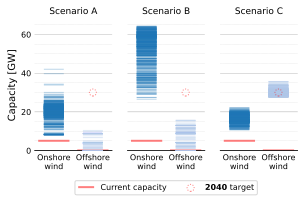

In [19]:
# Stripplots, one for each column of stats, each showing all configs
fig, axs = plt.subplots(1, 3, figsize=(12 * cm, 6 * cm), sharey=True)

# Draw simple wide rectangle as matplotlib path to use as marker in stripplot
marker = mpl.path.Path(
    [
        (-10, -0.5),
        (10, -0.5),
        (10, 0.5),
        (-10, 0.5),
        (-10, -0.5),
    ]
)

for ax, config in zip(axs.flatten(), configs):
    # Plot strip plot of onwind and offwind in the given config, one for each
    sns.stripplot(
        data=stats.loc[config][["onwind", "offwind"]] / 1000,
        # Dark blue, light blue hue
        palette=["#1f77b4", "#aec7e8"],
        marker=marker,
        size=20,
        jitter=0,
        alpha=0.3,
        ax=ax,
    )

    current_caps = (5.073, 0.088)
    # Add red horizontal lines for current capacity, at 0+-0.4 and 1+-0.4 resp.
    for i, cap in enumerate(current_caps):
        current_line = ax.hlines(
            y=cap,
            xmin=i - 0.4,
            xmax=i + 0.4,
            color="red",
            # linestyle="--",
            linewidth=2,
            alpha=0.5,
        )

    offwind_target_2040 = 30
    # Add dashed circle for 2040 target
    target_line = ax.scatter(
        x=1,
        y=offwind_target_2040,
        marker="o",
        s=50,
        alpha=0.5,
        linewidth=1,
        facecolors="none",
        edgecolors="red",
        linestyle=":",
        zorder=10,
    )

    ax.set_ylim(
        0,
        1.05
        * max(
            stats.loc[config][["onwind", "offwind"]].max().max() / 1000
            for config in configs
        ),
    )

    # Major and minor y grid
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.3, color="grey")
    ax.yaxis.grid(True, which="minor", linestyle=":", linewidth=0.2, color="grey")
    ax.set_axisbelow(True)

    # Turn off tick marks
    ax.tick_params(axis="both", which="both", length=0, labelsize=ticksize)

    # Turn of all but bottom spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set plot title, locate below plot
    ax.set_title(f"Scenario {config[-1]}", fontsize=titlesize)

    # Capitalise x tick labels rotate 20 degrees
    ax.set_xticklabels(["Onshore\nwind", "Offshore\nwind"], fontsize=labelsize)

# Add legend with current capacity and 2040 target, centered below plot
axs[1].legend(
    [current_line, target_line],
    [
        "Current capacity",
        "$\mathbf{2040}$ target",
    ],
    loc="upper center",
    fontsize=8,
    bbox_to_anchor=(0.5, -0.2),
    ncol=2,
)

# Shared y label
axs[0].set_ylabel("Capacity [GW]")

if save_figs:
    fig.savefig("figures/onwind_offwind.png", bbox_inches="tight", dpi=300)

/tmp/ipykernel_1452227/3225677087.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Scenario A", "Scenario B", "Scenario C"])


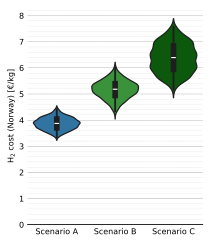

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8 * cm, 10 * cm))
sns.violinplot(
    data=stats.reset_index(),
    x="level_0",
    y="H2 cost",
    hue="level_0",
    palette=config_colours,
    # marker=marker,
    # size=30,
    # jitter=0,
    # alpha=0.1,
    ax=ax,
)
ax.set_ylim(0, max(stats["H2 cost"]) * 1.1)

ax.set_ylabel("H$_2$ cost (Norway) [€/kg]", fontsize=labelsize)
ax.set_xlabel("")

# Major and minor y grid (first set minor ticks at 0.1)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.3, color="grey")
ax.yaxis.grid(True, which="minor", linestyle=":", linewidth=0.2, color="grey")
ax.set_axisbelow(True)

# Turn off tick marks
ax.tick_params(axis="both", which="both", length=0, labelsize=ticksize)

# Turn of all but bottom spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Give x tick labels prettier names
ax.set_xticklabels(["Scenario A", "Scenario B", "Scenario C"])

if save_figs:
    fig.savefig("figures/H2_cost.png", bbox_inches="tight", dpi=300)

In [22]:
# Print mean as well as 5th and 95th percentile
for config in configs:
    print(
        f"Scenario {config[-1]}: {stats.loc[config]['H2 cost'].median():.2f} "
        f"({stats.loc[config]['H2 cost'].quantile(0.05):.2f} - "
        f"{stats.loc[config]['H2 cost'].quantile(0.95):.2f})"
    )

Scenario A: 3.87 (3.50 - 4.23)
Scenario B: 5.18 (4.61 - 5.72)
Scenario C: 6.39 (5.54 - 7.25)


In [24]:
# Print mean as well as 5th and 95th percentile of H2 production cost
for config in configs:
    print(
        f"Scenario {config[-1]}: {stats.loc[config]['H2 production cost'].median():.2f} "
        f"({stats.loc[config]['H2 production cost'].quantile(0.05):.2f} - "
        f"{stats.loc[config]['H2 production cost'].quantile(0.95):.2f})"
    )

Scenario A: 2.34 (2.05 - 2.63)
Scenario B: 3.43 (2.95 - 3.83)
Scenario C: 4.51 (3.78 - 5.17)


# Model maps

In [25]:
def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue
            names = ifind.index[ifind == i]
            c.df.loc[names, "location"] = names.str[:i]

/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('fac

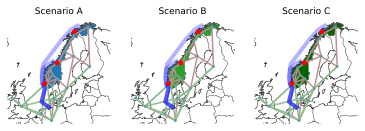

In [26]:
proj = ccrs.LambertConformal(central_longitude=15, central_latitude=65)
boundaries = [-6, 30, 50, 71]

# Cartopy map of Norway, projection centered on Norway
fig, axs = plt.subplots(
    1,
    3,
    figsize=(16 * cm, 13 * cm),
    subplot_kw={"projection": proj},
)

for ax, config in zip(axs.flatten(), configs):
    ax.set_extent(boundaries, crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m", color="grey", linewidth=0.5)
    # ax.add_feature(ccrs.cartopy.feature.LAND, color="lightgrey")
    # ax.add_feature(ccrs.cartopy.feature.OCEAN, color="lightgrey")

    # Highlight Norway (but only the country Norway) in light grey
    ax.add_feature(
        ccrs.cartopy.feature.BORDERS,
        edgecolor="lightgrey",
        facecolor="none",
        linewidth=0.5,
    )

    # Plot Norway in light grey
    shapename = "admin_0_countries"
    countries_shp = shapereader.natural_earth(
        resolution="50m", category="cultural", name=shapename
    )
    countries = shapereader.Reader(countries_shp).records()
    norway = [
        country for country in countries if country.attributes["NAME"] == "Norway"
    ][0]
    ax.add_geometries(
        [norway.geometry],
        ccrs.PlateCarree(),
        facecolor=config_colours[config],
        edgecolor="none",
        zorder=1,
    )

    # Plot searoute from Bremerhaven to Stavanger
    bremerhaven = (8.5, 53.5)
    stavanger = (5.7, 58.9)
    trondheim = (10.37, 63.44)
    tromso = (18.9, 69.6)
    routes = [sr.searoute(bremerhaven, c) for c in [stavanger, trondheim, tromso]]
    routes = gpd.GeoDataFrame.from_features(routes)
    routes.plot(
        ax=ax,
        color="blue",
        linewidth=4,
        zorder=10,
        alpha=0.3,
        transform=ccrs.PlateCarree(),
    )

    # Mark each location in Norway with a red dot
    for p in [stavanger, trondheim, tromso]:
        ax.plot(
            p[0],
            p[1],
            "o",
            color="red",
            markersize=4,
            transform=ccrs.PlateCarree(),
            zorder=10,
        )

    # Plot buses with location
    n = list(nets[config].values())[0]
    assign_location(n)
    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)
    n.plot(ax=ax, bus_sizes=0.2, color_geomap=None, boundaries=boundaries)

    ax.set_title(f"Scenario {config[-1]}", fontsize=titlesize)

if save_figs:
    plt.savefig("figures/map.png", bbox_inches="tight", dpi=300)
    plt.savefig("figures/map.pdf", bbox_inches="tight")

# Electricity prices

/tmp/ipykernel_1452227/3597101847.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("figures/map_costs.png", bbox_inches="tight", dpi=300)
/tmp/ipykernel_1452227/3597101847.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


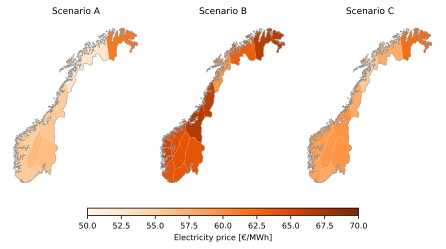

In [27]:
# Cartopy map of Norway, projection centered on Norway
fig, axs = plt.subplots(
    1,
    3,
    figsize=(16 * cm, 13 * cm),
    subplot_kw={"projection": proj},
    layout="tight",
)

cmap = mpl.cm.get_cmap("Oranges")
# norm = mpl.colors.BoundaryNorm(np.arange(50, 71, 4), cmap.N)
# Use continuous scale instead
norm = mpl.colors.Normalize(vmin=50, vmax=70)

for ax, config in zip(axs.flatten(), configs):
    # Draw Norwegian borders
    shapename = "admin_0_countries"
    countries_shp = shapereader.natural_earth(
        resolution="10m", category="cultural", name=shapename
    )
    countries = shapereader.Reader(countries_shp).records()
    norway = [
        country for country in countries if country.attributes["NAME"] == "Norway"
    ][0]
    ax.add_geometries(
        [norway.geometry],
        ccrs.PlateCarree(),
        facecolor="none",
        edgecolor="#808080",
        linewidth=0.4,
        zorder=10,
    )

    # Load regions of network as geojson
    s = config_dicts[config]["scenario"]["simpl"][0]
    c = config_dicts[config]["scenario"]["clusters"][0]
    regions = gpd.read_file(
        f"../resources/{config}/regions_onshore_elec_s{s}_{c}.geojson"
    )
    regions.set_index("name", inplace=True, drop=True)

    elec_prices = [
        n.snapshot_weightings.objective
        @ n.buses_t.marginal_price[regions.index].values
        / 8760
        for n in nets[config].values()
    ]
    regions["price"] = inflation * np.mean(elec_prices, axis=0)

    # Narrow down to just Norway
    n = list(nets[config].values())[0]
    regions["country"] = n.buses.loc[regions.index, "country"]
    regions = regions[regions.country == "NO"]

    # Plot regions with mean electricity price
    proj4 = proj.proj4_init
    regions = regions.to_crs(proj4)
    regions.plot(
        ax=ax,
        column="price",
        cmap=cmap,
        norm=norm,
        # zorder=20,
        legend=False,
    )

    # Turn of all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_title(f"Scenario {config[-1]}", fontsize=titlesize)

# Joint colorbar for all subplots, located below
cax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cb = mpl.colorbar.ColorbarBase(
    cax,
    cmap=cmap,
    norm=norm,
    orientation="horizontal",
    label="Electricity price [€/MWh]",
)
# Set tick and font size
cb.ax.tick_params(labelsize=ticksize)
cb.ax.xaxis.label.set_size(labelsize)

if save_figs:
    plt.savefig("figures/map_costs.png", bbox_inches="tight", dpi=300)

fig.tight_layout()
plt.show()

In [28]:
NO_buses = n.buses.loc[(n.buses.country == "NO") & (n.buses.carrier == "AC")].index

for config in configs:
    print(config)

    elec_prices = pd.DataFrame(
        [
            inflation
            * n.snapshot_weightings.objective
            @ (n.buses_t.marginal_price[NO_buses] * n.loads_t.p_set[NO_buses])
            / (n.snapshot_weightings.objective @ n.loads_t.p_set[NO_buses])
            for n in nets[config].values()
        ],
        columns=NO_buses,
    )

    p_total = n.snapshot_weightings.objective @ n.loads_t.p_set[NO_buses]

    total_prices = (elec_prices * p_total).sum(axis=1) / p_total.sum()
    print("Mean: ", total_prices.mean().round(0))
    print("Quantiles: ", total_prices.quantile([0.05, 0.95]).round(0).to_dict())

    # Aggregate to three groups: south, middle, north
    n.buses["group"] = "south"
    n.buses.loc[n.buses.y > 63, "group"] = "middle"
    n.buses.loc[n.buses.y > 67, "group"] = "north"
    n.buses.loc[n.buses.country != "NO", "group"] = "other"

    grouped_prices = (
        (elec_prices * p_total).groupby(n.buses.group, axis=1).sum()
    ) / p_total.groupby(n.buses.group).sum()
    # Order columns south to north
    grouped_prices = grouped_prices[["south", "middle", "north"]]

    print("Mean: ", grouped_prices.mean().round(0))
    # 5-95th percentiles:
    print(grouped_prices.quantile([0.05, 0.95]).round(0))

scenario_A


Mean:  56.0
Quantiles:  {0.05: 50.0, 0.95: 63.0}
Mean:  group
south     56.0
middle    56.0
north     56.0
dtype: float64
group  south  middle  north
0.05    49.0    49.0   50.0
0.95    63.0    62.0   62.0
scenario_B
Mean:  64.0
Quantiles:  {0.05: 56.0, 0.95: 71.0}
Mean:  group
south     64.0
middle    67.0
north     64.0
dtype: float64
group  south  middle  north
0.05    56.0    58.0   56.0
0.95    71.0    74.0   70.0
scenario_C
Mean:  59.0
Quantiles:  {0.05: 52.0, 0.95: 66.0}
Mean:  group
south     59.0
middle    59.0
north     59.0
dtype: float64
group  south  middle  north
0.05    52.0    51.0   52.0
0.95    66.0    66.0   66.0


# Onshore, offshore wind by region

In [31]:
onshore_caps = {}
for config in configs:
    onwind = (
        pd.concat(
            [
                n.generators.loc[n.generators.carrier == "onwind"]
                .groupby("bus")
                .sum()[["p_nom_opt"]]
                / 1e3
                for n in nets[config].values()
            ]
        )
        .groupby(level=0)
        .mean()
    )
    offwind = (
        pd.concat(
            [
                n.generators.loc[
                    n.generators.carrier.isin(
                        ["offwind-dc", "offwind-ac", "offwind-float"]
                    )
                ]
                .groupby("bus")
                .sum()[["p_nom_opt"]]
                / 1e3
                for n in nets[config].values()
            ]
        )
        .groupby(level=0)
        .mean()
    )
    df = pd.concat([onwind, offwind], axis=1)
    df.columns = ["onwind", "offwind"]
    onshore_caps[config] = df.loc[df.index.str.contains("NO")]

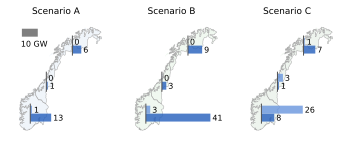

In [32]:
GW_per_pt = 1.0

n = list(nets["scenario_A"].values())[0]

# Cartopy map of Norway, projection centered on Norway
fig, axs = plt.subplots(
    1,
    3,
    figsize=(15 * cm, 14 * cm),
    subplot_kw={
        "projection": ccrs.LambertConformal(central_longitude=15, central_latitude=65)
    },
)
boundaries = [3, 27, 56, 72]
for ax, config in zip(axs.flatten(), configs):
    ax.set_extent(boundaries, crs=ccrs.PlateCarree())

    # Shade Norway
    shapename = "admin_0_countries"
    countries_shp = shapereader.natural_earth(
        resolution="50m", category="cultural", name=shapename
    )
    countries = shapereader.Reader(countries_shp).records()
    norway = [
        country for country in countries if country.attributes["NAME"] == "Norway"
    ][0]
    ax.add_geometries(
        [norway.geometry],
        ccrs.PlateCarree(),
        facecolor=config_colours[config] + "11",
        edgecolor="none",
        zorder=1,
    )

    # When plotting things on the map, we need to transform from the coordinate
    # system used by the PyPSA network to the current map projection.
    transform = pypsa.plot.get_projection_from_crs(n.srid)
    x, y = n.buses.x.copy(), n.buses.y.copy()

    x, y, _ = proj.transform_points(transform, x, y).T
    x = pd.Series(x, index=n.buses.index)
    y = pd.Series(y, index=n.buses.index)

    length = fig.bbox_inches.width * ax.get_position().width
    value_range = np.diff(ax.get_xlim())[0]
    pt = value_range / (length * 72)

    bar_width = 8

    # Load wind capacities
    df = onshore_caps[config]

    # Aggregate to three groups: south, middle, north
    n.buses["group"] = "south"
    n.buses.loc[n.buses.y > 63, "group"] = "middle"
    n.buses.loc[n.buses.y > 67, "group"] = "north"
    n.buses.loc[n.buses.country != "NO", "group"] = "other"
    df = df.groupby(n.buses["group"], axis=0).sum()
    x = x.groupby(n.buses["group"]).mean()
    y = y.groupby(n.buses["group"]).mean()

    colours = [
        config_dicts[config]["plotting"]["tech_colors"]["onwind"],
        config_dicts[config]["plotting"]["tech_colors"]["offwind"],
    ]

    width_scale = 1.6

    for b in df.index:
        # Plot base line
        bx, by = x.loc[b], y.loc[b]
        ax.plot(
            [bx, bx],
            [
                by - bar_width * (len(df.columns) / 2 + 0.2) * pt,
                by + bar_width * (len(df.columns) / 2 + 0.2) * pt,
            ],
            linewidth=1,
            color="#505050",
            zorder=10,
        )
        # Plot investment bars
        for i, d in enumerate(df.loc[b]):
            ax.add_patch(
                mpl.patches.Rectangle(
                    xy=(bx, by + bar_width * (-len(df.columns) / 2 + i) * pt),
                    width=d * pt * width_scale,
                    height=bar_width * pt,
                    facecolor=colours[i],
                    zorder=9,
                    alpha=0.8,
                )
            )

            ax.text(
                x=bx + d * pt * width_scale + 2 * pt,
                y=by + bar_width * (-len(df.columns) / 2 + i) * pt + 1 * pt,
                s=f"{d:.0f}",
                fontsize=labelsize,
                zorder=10,
            )

    s = config_dicts[config]["scenario"]["simpl"][0]
    c = config_dicts[config]["scenario"]["clusters"][0]
    onshore_regions = gpd.read_file(
        f"../resources/{config}/regions_onshore_elec_s{s}_{c}.geojson"
    )
    onshore_regions.set_index("name", inplace=True)
    onshore_regions = onshore_regions.to_crs(proj4)

    # Restrict to onshore regions in Norway
    onshore_regions = onshore_regions.loc[onshore_regions.index.str.contains("NO")]

    # Aggregate to three groups: south, middle, north
    onshore_regions["group"] = "south"
    onshore_regions.loc[onshore_regions.index.map(n.buses.y) > 63, "group"] = "middle"
    onshore_regions.loc[onshore_regions.index.map(n.buses.y) > 67, "group"] = "north"

    onshore_regions = onshore_regions.dissolve(by="group")

    # Plot boundaries of onshore regions
    onshore_regions.plot(
        ax=ax,
        facecolor="none",
        edgecolor="#aaaaaa",
        linewidth=0.5,
        zorder=1,
    )

    ax.set_title(f"Scenario {config[-1]}", fontsize=titlesize)

    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

# legend_coords = (20, 58)
legend_coords = (3, 70)

axs[0].add_patch(
    mpl.patches.Rectangle(
        xy=proj.transform_point(*legend_coords, ccrs.PlateCarree()),
        height=bar_width * pt,
        width=(10 / GW_per_pt) * pt * width_scale,
        facecolor="black",
        zorder=10,
        alpha=0.5,
    )
)
axs[0].annotate(
    xy=legend_coords,  # proj.transform_point(2.5, 68, ccrs.PlateCarree()),
    xycoords=ccrs.PlateCarree(),
    textcoords="offset points",
    xytext=(-1, -bar_width - 2),
    text="10 GW",
    fontsize=labelsize,
)

if save_figs:
    plt.savefig("figures/map_wind.png", bbox_inches="tight", dpi=300)

plt.show()

In [43]:
n = list(nets["scenario_A"].values())[0]

n.buses["group"] = "south"
n.buses.loc[n.buses.y > 63, "group"] = "middle"
n.buses.loc[n.buses.y > 67, "group"] = "north"
n.buses.loc[n.buses.country != "NO", "group"] = "other"

grouped_caps = {
    config: onshore_caps[config]
    .groupby(n.buses["group"], axis=0)
    .sum()
    .round(1)
    .loc[["north", "middle", "south"]]
    for config in configs
}

for config, df in grouped_caps.items():
    df["area"] = (df["onwind"] * 1000 * sqkm_per_MW).round(0)
    df["total_avail_area"] = pd.Series(
        # Numbers are taken from the "area" notebook
        {"north": 55279, "middle": 24644, "south": 57690}
    )
    df["perc_used_area"] = (100 * df["area"] / df["total_avail_area"]).round(1)
    df.loc["total"] = df.sum()
    df.loc["total", "perc_used_area"] = (
        100 * df.loc["total", "area"] / df.loc["total", "total_avail_area"]
    ).round(1)

    print(f"Scenario {config[-1]}")
    print(df)

Scenario A
        onwind  offwind    area  total_avail_area  perc_used_area
group                                                            
north      5.6      0.0   651.0           55279.0             1.2
middle     0.9      0.0   105.0           24644.0             0.4
south     13.1      1.1  1523.0           57690.0             2.6
total     19.6      1.1  2279.0          137613.0             1.7
Scenario B
        onwind  offwind    area  total_avail_area  perc_used_area
group                                                            
north      8.9      0.0  1035.0           55279.0             1.9
middle     2.8      0.1   326.0           24644.0             1.3
south     40.6      2.7  4721.0           57690.0             8.2
total     52.3      2.8  6082.0          137613.0             4.4
Scenario C
        onwind  offwind    area  total_avail_area  perc_used_area
group                                                            
north      7.4      0.8   860.0           5

region
north      707.65
middle    1758.53
south     2541.55
Name: effekt_MW_idrift, dtype: float64

5007.73

region
north      82.0
middle    204.0
south     296.0
Name: effekt_MW_idrift, dtype: float64

582.2941860465116

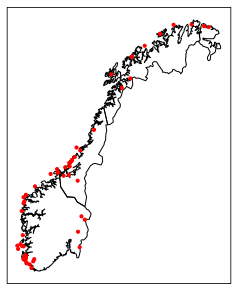

In [34]:
windparks = gpd.read_file("vindparker.geojson")

# Convert onshore_regions to lat:lon
R = onshore_regions.to_crs(proj4)
windparks = windparks.to_crs(proj4)

# Group windparks by which region they belong to, i.e. which onshore region they are closest to
windparks["region"] = windparks.geometry.apply(
    lambda x: R.distance(x).idxmin()
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": proj})
onshore_regions.plot(ax=ax, edgecolor="black", facecolor="none")
windparks.plot(ax=ax, color="red", markersize=10)

effekt = windparks[["region", "effekt_MW_idrift"]].groupby("region").sum()["effekt_MW_idrift"][["north", "middle", "south"]]
display(effekt)
display(effekt.sum())

areal = effekt * sqkm_per_MW
display(areal.round(0))
display(areal.sum())

# Sensitivity analysis

In [35]:
# Use salib to analyse sensitivity of H2 cost to input parameters
sa_stats = stats[["H2 cost"]].copy()
params = list(set([p for c in config_dicts.values() for p in c["param_sweep"]]))
for config in configs:
    param_config = config_dicts[config]["param_sweep"]
    for f in sa_stats.loc[config].index:
        n = nets[config][f]
        for p in params:
            carrier = param_config[p]["carrier"]
            attr = param_config[p]["attr"]

            # Find the factor for this parameters in the file name f, which is of the form <carrier>+<attr><factor>. The factor is a float. Use regex.
            m = re.search(f"{carrier}\+{attr}(\d+\.\d+)", f)
            if m is None:
                factor = 1
            else:
                factor = float(m.group(1))
            sa_stats.loc[(config, f), p] = factor

# Invert export efficiency
sa_stats["electrolysis_efficiency"] = 1 / sa_stats["electrolysis_efficiency"]

R^2 for scenario_A: 0.9978665892229113
R^2 for scenario_B: 0.9805783952135345
R^2 for scenario_C: 0.9984038614182815


/tmp/ipykernel_1452227/4219434596.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


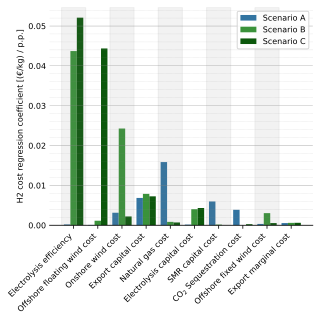

In [36]:
# Perform linear regression of H2 cost on input parameters
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(1, 1, figsize=(12 * cm, 10 * cm))
lrs = {}
for config in configs:
    X = sa_stats.loc[config][params].values
    Y = sa_stats.loc[config]["H2 cost"].values
    lrs[config] = LinearRegression().fit(X, Y)
    print(f"R^2 for {config}: {lrs[config].score(X, Y)}")

# Plot bar plot of coefficients as above
df = pd.concat(
    [pd.Series(lrs[config].coef_, index=params, name=config) for config in configs],
    axis=1,
)

# Sort index by average coefficient
df = df.loc[df.abs().sum(axis=1).sort_values(ascending=False).index]
labels = df.index

df = df.reset_index().melt(id_vars="index", var_name="config", value_name="coef")
df["coef"] /= 100  # Convert to %
sns.barplot(
    data=df,
    x="index",
    y="coef",
    hue="config",
    ax=ax,
    palette=config_colours,
)

# Create an alternating shading pattern to help readability by shading the whole graph from x=n-0.5 to x=n+0.5 for n even
for i in range(len(labels)):
    if i % 2 == 0:
        ax.axvspan(i - 0.5, i + 0.5, alpha=0.1, color="grey")

ax.set_ylabel("H2 cost regression coefficient [(€/kg) / p.p.]", fontsize=labelsize)
ax.set_xlabel("")

# Rotate x ticks
# Params:
pretty_param_names = {
    "electrolysis_efficiency": "Electrolysis efficiency",
    "electrolysis_cost": "Electrolysis capital cost",
    "onwind_cost": "Onshore wind cost",
    "SMR_cost": "SMR capital cost",
    "gas_cost": "Natural gas cost",
    "offwind-fixed_cost": "Offshore fixed wind cost",
    "export_capital_cost": "Export capital cost",
    "export_marginal_cost": "Export marginal cost",
    "offwind-float_cost": "Offshore floating wind cost",
    "sequestration_cost": "CO$_2$ Sequestration cost",
}
ax.set_xticklabels(
    [pretty_param_names[p] for p in labels],
    rotation=45,
    ha="right",
    fontsize=ticksize,
)

ax.set_ylim(bottom=0)

# Format legend labels
handles, labels = ax.get_legend_handles_labels()
labels = [f"Scenario {l[-1]}" for l in labels]
ax.legend(handles, labels, fontsize=labelsize)

# Remove legend title
ax.get_legend().set_title("")

# Turn off all but bottom spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Auto location of minor ticks
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

# Turn on major and minor grid lines
ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.3, color="grey")
ax.yaxis.grid(True, which="minor", linestyle=":", linewidth=0.2, color="grey")

# Turn of y tick marks
ax.tick_params(axis="y", which="both", length=0, labelsize=ticksize)

if save_figs:
    fig.savefig("figures/sensitivity.png", bbox_inches="tight", dpi=300)
plt.show()

# Investment ranges

In [37]:
def rename_techs(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        "H2 Electrolysis": "hydrogen",
        "H2 Fuel Cell": "hydrogen",
        "H2 pipeline": "hydrogen",
        "battery": "battery storage",
        "CC": "CCS",
    }

    rename = {
        "solar rooftop": "solar",
        "Sabatier": "hydrogen",
        "Fischer-Tropsch": "hydrogen",
        "H2": "hydrogen",
        "offwind": "offshore wind",
        "offwind-ac": "offshore wind",
        "offwind-dc": "offshore wind",
        "offwind-float": "offshore wind",
        "onwind": "onshore wind",
        "ror": "hydro",
        "hydro": "hydro",
        "PHS": "hydro",
        "co2 Store": "DAC",
        "co2 stored": "CCS",
        "AC": "transmission",
        "DC": "transmission",
        "B2B": "transmission",
        "air heat pump": "electric heating",
        "ground heat pump": "electric heating",
        "resistive heater": "electric heating",
        "uranium": "nuclear",
        "solid biomass transport": "biomass,biogas",
        "solid biomass": "biomass,biogas",
        "biogas": "biomass,biogas",
        "gas": "gas,heating,CHP",
        "CHP": "gas,heating,CHP",
        "OCGT": "gas,heating,CHP",
        "gas boiler": "gas,heating,CHP",
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label


preferred_order = pd.Index(
    [
        "solar",
        "onshore wind",
        "offshore wind",
        "offshore wind (AC)",
        "offshore wind (DC)",
        "hydrogen",
        "transmission",
        "electricity distribution grid",
        "nuclear",
        "hydro",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "electric heating",
        "gas,heating,CHP",
        "solid biomass",
        "biogas",
        "biomass,biogas",
        "solar PV",
        "solar thermal",
        "solar rooftop",
        "solar",
        "building retrofitting",
        "ground heat pump",
        "air heat pump",
        "heat pump",
        "resistive heater",
        "electric heating",
        "power-to-heat",
        "gas-to-power/heat",
        "CHP",
        "OCGT",
        "gas boiler",
        "gas",
        "natural gas",
        "helmeth",
        "methanation",
        "hydrogen storage",
        "power-to-gas",
        "power-to-liquid",
        "battery storage",
        "hot water storage",
        "CO2 sequestration",
    ]
)

# Load yaml config
plot_config = config_dicts["scenario_A"]["plotting"]
plot_config["tech_colors"]["transmission"] = plot_config["tech_colors"][
    "transmission lines"
]
plot_config["tech_colors"]["carbon capture"] = plot_config["tech_colors"]["CC"]
plot_config["tech_colors"]["hydrogen"] = plot_config["tech_colors"]["hydrogen storage"]
plot_config["tech_colors"]["electric heating"] = plot_config["tech_colors"]["heat pump"]
plot_config["tech_colors"]["marginal costs"] = "#909090"
plot_config["tech_colors"]["biomass,biogas"] = plot_config["tech_colors"][
    "solid biomass"
]
plot_config["tech_colors"]["gas,heating,CHP"] = plot_config["tech_colors"]["gas"]

opt_name = {"Store": "e", "Line": "s", "Transformer": "s"}


def calculate_costs(n, label, costs):

    for c in n.iterate_components(
        n.branch_components | n.controllable_one_port_components ^ {"Load"}
    ):
        capital_costs = c.df.capital_cost * c.df[opt_name.get(c.name, "p") + "_nom_opt"]
        capital_costs_grouped = capital_costs.groupby(c.df.carrier).sum()

        capital_costs_grouped = pd.concat([capital_costs_grouped], keys=["capital"])
        capital_costs_grouped = pd.concat([capital_costs_grouped], keys=[c.list_name])

        costs = costs.reindex(capital_costs_grouped.index.union(costs.index))

        costs.loc[capital_costs_grouped.index, label] = capital_costs_grouped

        if c.name == "Link":
            p = c.pnl.p0.multiply(n.snapshot_weightings.generators, axis=0).sum()
        elif c.name == "Line":
            continue
        elif c.name == "StorageUnit":
            p_all = c.pnl.p.multiply(n.snapshot_weightings.generators, axis=0)
            p_all[p_all < 0.0] = 0.0
            p = p_all.sum()
        else:
            p = c.pnl.p.multiply(n.snapshot_weightings.generators, axis=0).sum()

        # correct sequestration cost
        if c.name == "Store":
            items = c.df.index[
                (c.df.carrier == "co2 stored") & (c.df.marginal_cost <= -100.0)
            ]
            c.df.loc[items, "marginal_cost"] = -20.0

        marginal_costs = p * c.df.marginal_cost

        marginal_costs_grouped = marginal_costs.groupby(c.df.carrier).sum()

        marginal_costs_grouped = pd.concat([marginal_costs_grouped], keys=["marginal"])
        marginal_costs_grouped = pd.concat([marginal_costs_grouped], keys=[c.list_name])

        costs = costs.reindex(marginal_costs_grouped.index.union(costs.index))

        costs.loc[marginal_costs_grouped.index, label] = marginal_costs_grouped

    return costs

In [38]:
config = "scenario_B"

cost_df = pd.DataFrame()

for f, n in nets[config].items():
    cost_df = calculate_costs(n, f, cost_df)

df = cost_df.groupby(cost_df.index.get_level_values(2)).sum()
df = df / 1e9
df = df.groupby(df.index.map(rename_techs)).sum()
to_drop = df.index[df.max(axis=1) < plot_config["costs_threshold"]]
df = df.drop(to_drop)
new_index = preferred_order.intersection(df.index).append(
    df.index.difference(preferred_order)
)
new_columns = df.sum().sort_values().index
df = df.loc[new_index, new_columns]

/tmp/ipykernel_1452227/4243071065.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df.index)


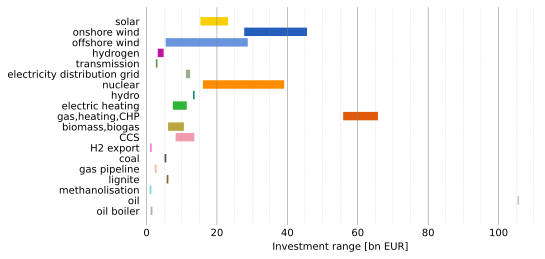

In [39]:
# Plot bars indicating the maximum and minimum cost for each row of df
fig, ax = plt.subplots(figsize=(18 * cm, 10 * cm))
ax.barh(
    y=df.index,
    width=(df.max(axis=1) - df.min(axis=1)).clip(0.5, None),
    left=df.min(axis=1),
    color=[plot_config["tech_colors"][c] for c in df.index],
)

# Flip the y-axis so that the largest cost is at the top
ax.invert_yaxis()

# Set lower x axis limit to 0
ax.set_xlim(left=-1)

# Set font size for labels and ticks
ax.tick_params(axis="both", which="major")
ax.set_yticklabels(df.index)

# Turn off tick marks
ax.tick_params(axis="both", which="both", length=0)

# Turn off all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Major and minor x grid at multiples of 100 and 20
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.grid(which="major", axis="x", linestyle="-", linewidth="0.5", color="grey", zorder=0)
ax.grid(
    which="minor", axis="x", linestyle=":", linewidth="0.25", color="grey", zorder=0
)


# x axis label
ax.set_xlabel("Investment range [bn EUR]")

# plt.savefig(f"figures/total-costs-{config_name}.pdf", bbox_inches="tight")
plt.show()